### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

import sys, os

# include parent directory in import path
# sys.path.insert(1, os.path.join(sys.path[0], "../python_source"))
sys.path.insert(1, os.path.join(os.getcwd(), "../python_source"))

from QFIM_SMSV import *

from operators import *
from states import *
from loss_channels import *
from encoding_channels import *
from fisher_information import *
from plotters import *

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colors, colorbar, colormaps

# LaTeX fonts
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["lines.linewidth"] = 2
plt.rcParams.update({"font.size": 18})

# Bang Wong color blind--friendly colours
COLOURS = {
    "Black": "#000000",
    "Orange": "#E69F00",
    "Sky blue": "#56B4E9",
    "Bluish green": "#009E73",
    "Yellow": "#F0E442",
    "Blue": "#0072B2",
    "Vermillion": "#D55E00",
    "Reddish purple": "#CC79A7",
}

π = np.pi

Autosaving every 60 seconds


### Style methods

In [2]:
def grid(ax, zorder=0):
    ax.grid("both", "both", color="gainsboro", zorder=zorder)


def legend(ax, reversed=False, **kwargs):
    defaults = dict(handlelength=1, labelspacing=0, frameon=False, handletextpad=0.3)
    if reversed:
        h, l = ax.get_legend_handles_labels()
        ax.legend(handles=reversed(h), labels=reversed(l), **(defaults | kwargs))
    else:
        ax.legend(**(defaults | kwargs))


def plot_options(
    key,
    # n_input=None,
    **kwargs,
):
    defaults = {
        "vacuum": dict(
            color=COLOURS["Orange"], label=r"vacuum QFI (CFI $\hat n$)", linewidth=3
        ),
        "vacuum quadrature CFI": dict(
            # color=COLOURS["Yellow"],
            # color=COLOURS["Reddish purple"],
            color=COLOURS["Sky blue"],
            # linestyle="--",
            linestyle=(0, (2, 1)),
            linewidth=3,
            label=r"vacuum CFI $\hat p$",
        ),
        # to match vacuum
        "coherent": dict(
            color=COLOURS["Orange"],
            linestyle="-",
            label="Coherent",
        ),
        "SMSV": dict(
            color=COLOURS["Bluish green"],
            linestyle="-.",
            label="SMSV",
        ),
        "Fock": dict(
            color=COLOURS["Vermillion"],
            linestyle=":",
            label="Fock",
        ),
        "TMSV": dict(
            color=COLOURS["Sky blue"],
            linestyle="--",
            label="TMSV",
        ),
        "TMSV-PS": dict(
            color=COLOURS["Reddish purple"],
            linestyle=":",
            label="TMSV-PS",
        ),
        "cat": dict(
            color=COLOURS["Reddish purple"],
            linestyle=":",
            label="Cat",
        ),
        "channel": dict(
            color=COLOURS["Blue"],
            linestyle="-",
            label="Channel QFI",
            # linewidth=0.8,
        ),
    }
    # if key in ["SMSV QFI", "Fock QFI"] and n_input is None:
    #     raise ValueError("n_input not provided.")
    options = defaults[key]
    # union (|) returns a dict with the union of keys, preferencing the second slot in the case of key conflicts
    return options | kwargs


# is this problematic that we are repeating colours with a different meaning here?
colours = dict(
    Fock=COLOURS["Vermillion"], coherent=COLOURS["Sky blue"], channel=COLOURS["Blue"]
)

### TMSV

State

In [31]:
def TMSV_ket(N, r, θ):
    """Wavefunction complex amplitude for the |2n> Fock basis element."""
    ket = np.zeros_like(np.kron(vacuum(N), vacuum(N)))
    for n in range(N):
        ket += 1 / np.cosh(r) * (-np.exp(1j * θ) * np.tanh(r)) ** n * np.kron(fock_ket(N, n), fock_ket(N, n))
    return normalise(N ** 2, ket)

def RDM(D, state):
    """Reduced density matrix (RDM) tracing over the second site, i.e. the ancilla."""
    ρ = ρ_from_state(D**2, state)
    eigvs = np.linalg.eigh(Nhat(D)).eigenvectors
    ρs = np.zeros((D, D), dtype=complex)
    for eigv in eigvs.T:
        # partial trace = sum over the eigenbasis of the ancilla
        eigv_ext = np.kron(np.identity(D), eigv)
        ρs += dag(eigv_ext).T @ ρ @ eigv_ext.T
    return ρs

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Fock number', ylabel='Occupation probability'>,
        <Axes: xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

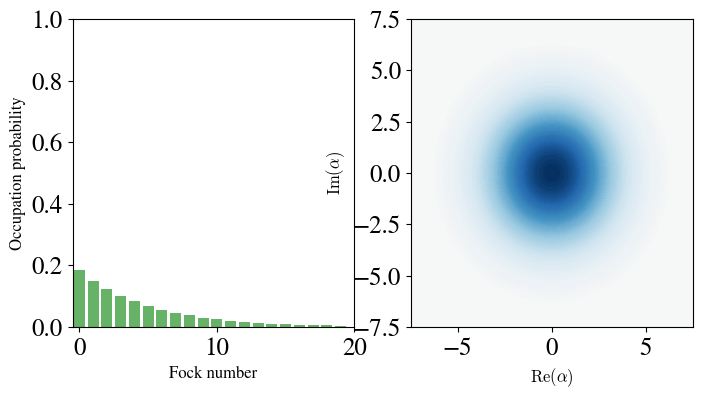

In [32]:
ket = TMSV_ket(N=20, r=1.5, θ=0)
rdm = RDM(D=20, state=ket)
plot_wigner(20, rdm)

Lossless

In [46]:
def gaussian(x, μ, σ):
    return 1 / (σ * math.sqrt(2 * math.pi)) * np.exp(-0.5 * ((x - μ) / σ)**2)

def displace_system(N, state, α, truncation=None):
    """Returns the state with the first subsystem displaced by D(α)."""
    U = np.kron(displacement_operator(N, α, truncation), np.identity(N))

    stype = state_type(N ** 2, state)
    if stype == "ket":
        return U @ state
    elif stype == "ρ":
        return U @ state @ dag(U)

def encoded_state(N, σ, ket):
    ρ0 = ρ_from_ket(ket)

    μ_max = 5 * σ
    μ_min = -μ_max
    μ_steps = 50
    μs = np.linspace(μ_min, μ_max, μ_steps)

    prior_μ = gaussian(μs, 0, σ)
    prior_μ /= np.trapz(y=prior_μ, x=μs)

    ρ_μs = np.zeros((*ρ0.shape, len(μs)), dtype=complex)
    for j, μ in enumerate(tqdm(μs, desc=f"Calculating ρ(μ) = D(α) |ψ><ψ| D(α)^† for all μs")):
        ρ_μs[:, :, j] = normalise(N ** 2, displace_system(N, ρ0, α=1j * μ / np.sqrt(2), truncation=None))

    # Calculating ρ_bar by integrating over μ
    ρ_bar = normalise(N ** 2, np.trapz(y=prior_μ * ρ_μs, x=μs))
    return ρ_bar

In [48]:
N = 20
r = 1.1
σ = 1e-3
δσ = 1e-5
##########

ket = TMSV_ket(N=N, r=r, θ=0) # TODO: check angle

σ1 = σ - δσ / 2
σ2 = σ + δσ / 2
ρ1 = encoded_state(N, σ1, ket)
ρ2 = encoded_state(N, σ2, ket)
ρ = normalise(N ** 2, 0.5 * (ρ1 + ρ2))

δρ = ρ2 - ρ1
ρ_dot = δρ / δσ

Fq = QFI_from_deriv(ρ, ρ_dot)
print(Fq)

Calculating ρ(μ) = D(α) |ψ><ψ| D(α)^† for all μs:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating ρ(μ) = D(α) |ψ><ψ| D(α)^† for all μs:   0%|          | 0/50 [00:00<?, ?it/s]

9.121441185486363


In [50]:
# lossless QFI should be 4 nbar for TMSV
# TODO: debug why it isn't here?
4 * average_number(N ** 2, ket)

149.62316815729235

Lossy